In [ ]:
!pip install geopandas

In [ ]:
import numpy as np
from shapely.geometry import MultiPoint
import geopandas as gpd
import pandas as pd
from geopandas import GeoSeries
from shapely.geometry import Polygon

p = [(0, 0),(0.25, 0), (0.5, 0), (0.75, 0), (1.0, 0), 
    (1, 0.25), (1, 0.5), (1, 0.75), (1, 1), 
    (0.75, 1), (0.5, 1), (0.25, 1), (0, 1), 
     (0, 0.75), (0, 0.5), (0, 0.25)]

px = Polygon(p)
g = GeoSeries(px)

<Axes: >

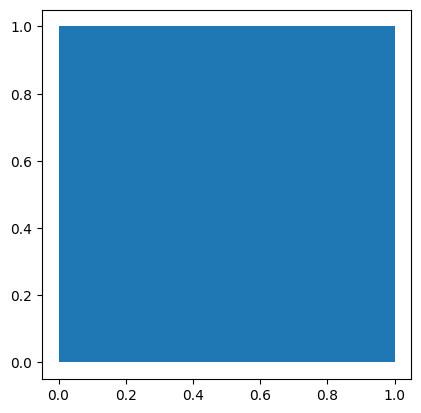

In [139]:
g.plot()

In [138]:
gdf = gpd.GeoDataFrame({
    "geometry":[px]
})
gdf

,geometry
0,"POLYGON ((0.00000 0.00000, 0.25000 0.00000, 0...."


In [140]:
# ポリゴンの外周を取得する
gdf.geometry = gdf.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))

<Axes: >

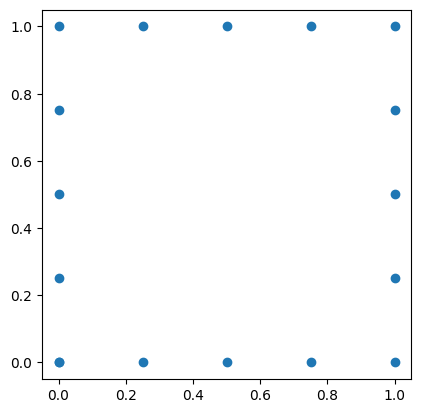

In [141]:
gdf.plot()

In [142]:
# 終点が追加されて+1行となる
ex = gdf.geometry.explode(index_parts=True)
ex

0  0     POINT (0.00000 0.00000)
   1     POINT (0.25000 0.00000)
   2     POINT (0.50000 0.00000)
   3     POINT (0.75000 0.00000)
   4     POINT (1.00000 0.00000)
   5     POINT (1.00000 0.25000)
   6     POINT (1.00000 0.50000)
   7     POINT (1.00000 0.75000)
   8     POINT (1.00000 1.00000)
   9     POINT (0.75000 1.00000)
   10    POINT (0.50000 1.00000)
   11    POINT (0.25000 1.00000)
   12    POINT (0.00000 1.00000)
   13    POINT (0.00000 0.75000)
   14    POINT (0.00000 0.50000)
   15    POINT (0.00000 0.25000)
   16    POINT (0.00000 0.00000)
Name: geometry, dtype: geometry

In [143]:
# geoseries to pd.DataFrame
df = pd.DataFrame({
    "x":ex.x,
    "y":ex.y
}).reset_index(drop=True)

In [144]:

# 局所曲率符号を定義する
# Cn_secがもとまる
cn_list = []
for c in range(df.shape[0] - 1):
    cc = c + 1
    if cc < df.shape[0] - 1: 
        fir = df.loc[cc-1,:].values
        sec = df.loc[cc,:].values
        thr = df.loc[cc+1,:].values
    else:
        fir = df.loc[cc-1,:].values
        sec = df.loc[cc,:].values
        thr = df.loc[1,:].values

    v1 = sec - fir
    v2 = thr - sec

    n1 = np.linalg.norm(v1, ord=2)
    n2 = np.linalg.norm(v2, ord=2)

    d = np.dot(v1, v2)

    cos = d / (n1 * n2)

    # Cn_secの角度
    theta = np.arccos(cos)
    theta = np.degrees(theta)
    print("theta", "Cn", cc, theta)

    # 局所方向符号:cn
    if (0 <= theta < 45):
        cn = 0
    elif (45 <= theta < 90):
        cn = 1
    elif (90 <= theta < 135):
        cn = 2
    elif (135 <= theta < 180):
        cn = 3
    elif (180 <= theta < 225):
        cn = 4
    elif (225 <= theta < 270):
        cn = 5
    elif (270 <= theta < 315):
        cn = 6
    elif (315 <= theta < 360):
        cn = 7

    print("局所方向符号", cn)
    cn_list.append(cn)

theta Cn 1 0.0
局所方向符号 0
theta Cn 2 0.0
局所方向符号 0
theta Cn 3 0.0
局所方向符号 0
theta Cn 4 90.0
局所方向符号 2
theta Cn 5 0.0
局所方向符号 0
theta Cn 6 0.0
局所方向符号 0
theta Cn 7 0.0
局所方向符号 0
theta Cn 8 90.0
局所方向符号 2
theta Cn 9 0.0
局所方向符号 0
theta Cn 10 0.0
局所方向符号 0
theta Cn 11 0.0
局所方向符号 0
theta Cn 12 90.0
局所方向符号 2
theta Cn 13 0.0
局所方向符号 0
theta Cn 14 0.0
局所方向符号 0
theta Cn 15 0.0
局所方向符号 0
theta Cn 16 90.0
局所方向符号 2


In [145]:
df = df.loc[:df.shape[0] - 2,:]
df

,x,y
0,0.00,0.00
1,0.25,0.00
2,0.50,0.00
3,0.75,0.00
4,1.00,0.00
5,1.00,0.25
6,1.00,0.50
7,1.00,0.75
8,1.00,1.00
9,0.75,1.00


In [146]:
cn_list.insert(0, cn_list[-1])
cn_list = cn_list[:-1]
df["Cn"] = cn_list

In [147]:
# 局所曲率符号: ca
# Cai = octmod(Cni - Cni-1 + 11) - 3
ca_list = []
for l in range(len(cn_list)):
    # llは1-8をとる　8をとるとout of range
    ll = l + 1
    if ll < len(cn_list):
        ca = ((cn_list[ll-1] - cn_list[ll] + 11 ) % 8 ) - 3
    else:
        ca = ((cn_list[ll-1] - cn_list[0] + 11 ) % 8 ) - 3
    ca_list.append(ca)

In [148]:
df["Ca"] = ca_list

In [149]:
def get_range_list(i, k):
    x = [tmp for tmp in range(df.shape[0])]
    xi = x.index(i)

    fir = xi - k
    sec = xi
    thr = xi + k

    if xi - k <= -1:
        under = df.shape[0] + xi - k
        tun = 0
    else:
        under = xi - k
        tun = 1

    if xi + k + 1 >= df.shape[0]:
        upper = xi + k + 1 - df.shape[0]
        tup = 0
    else:
        upper = xi + k + 1
        tup = 1
    if tun * tup == 1:
        r_l = x[under:upper]
    else:
        r_l = x[under:] + x[:upper]

    return r_l

In [156]:
# G-オペレーション
# M: Mは平滑化に用いる曲線上の連続した画素数
# Gi: 曲線の曲率半径が小さいほど、絶対値が大きくなる。
# 絶対値が大きい部分が曲線の角の部分であると考えられる
# +が左回り, -が右回り

M = 3
k = M - 1
s = 0
gi_list = []
for i in range(df.shape[0]):
    r_l = get_range_list(i, k)
    c = r_l.index(i)
    
    # CnとCaの値を抽出する
    tmp = df.loc[r_l, :]

    for tk in range(M-1) :
        ca_under = tmp.loc[r_l[c - tk], "Ca"]
        ca_upper = tmp.loc[r_l[c + tk], "Ca"]
        # print(ca_under, ca_upper)
        s = (M - k+1) * (ca_under + ca_upper) + s

    Gi = M * tmp.loc[i, "Ca"]  + s 
    print(Gi)
    gi_list.append(Gi)

10
8
4
-6
10
8
4
-6
10
8
4
-6
10
8
4
-6


In [157]:
df["Gi"] = gi_list

In [158]:
df

,x,y,Cn,Ca,Gi
0,0.00,0.00,2,2,10
1,0.25,0.00,0,0,8
2,0.50,0.00,0,0,4
3,0.75,0.00,0,-2,-6
4,1.00,0.00,2,2,10
5,1.00,0.25,0,0,8
6,1.00,0.50,0,0,4
7,1.00,0.75,0,-2,-6
8,1.00,1.00,2,2,10
9,0.75,1.00,0,0,8
